## Trial Prediction Exercise

### Objective

We want to build a model able to predict if a user is going to become a paying user of the Lingokids service after its trial expires. Remember the trial is 7 days. 
We have four sources of data that can be classified into two broad categories
1. Subscription data: This includes three different datasources
    * Information related to onboarding: All the actions that the user take to create its profile
    * Information related to subscription paywall: Here is where the user can opt to start a trial. It can be shown at different stages: it is always shown right after registration but it can also be shown after reaching daily limits or accesing limited features. If the user agrees to the trial is considered a succesful subscription and an invoice is charged after 7 days
    * Information related to the billing: After 7 days of a succesful subscription a bill is sent to the user. This means that the user has become a paying user (the event we want to predict)
2. Activity data: contains information about the activities that the user does within the app. 

This is a "sequence to class" prediction problem where we have a sequence of events and we want to know if they will end up on an specific target variable (user becomes a paying user). 

There are many approaches to this problem. In our case we are going to aggregate all the different events that happen over time for each user and engineer the features that will form part of the prediction model. Engineering all these features will require a lot of data wrangling and cleaning. Remember that we want to predict as soon as possible if we are going to have a paying user. We need to start giving predictions from the beginning which could seem a contradiction with aggregating over time. However it can be done by establishing a process that listens to the stream of events and updates the aggregated metrics of the different users as they arrive. Every period of time in a batch manner we can evaluate the prediction models with those updated counters. With those predictions, decisions can be taken (send a discount/reminder if the probability of becoming a paying user is low, extend the trial, etc...).

1. <a href='#onboard_data'>Onboard data</a>
1. <a href='#subscription_data'>Subscription data</a>
1. <a href='#invoice_data'>Invoice data</a>
1. <a href='#activities_data'>Activities data</a>
1. <a href='#create_dataset_and_training'>Create dataset and training</a>
1. <a href='#evaluation'>Evaluation</a>
1. <a href='#interpretability'>Interpretability</a>
1. <a href='#conclusion'>Conclusion</a>
1. <a href='#future_work'>Future work</a>

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from functools import reduce

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 2000)
pd.set_option('max_colwidth', 200000)
import json
from sklearn.impute import SimpleImputer

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_curve, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import KFold
import shap

import urllib.request
import os

fpath_activities = 'data/activities.tsv'
fpath_invoices = 'data/invoices.tsv'
fpath_onboard_events = 'data/onboarding_events.tsv'
fpath_subscription_events = 'data/subscription_events.tsv'

##### Note: Put the files activities.tsv, invoices.tsv, onboarding_events.tsv and subscription_events.tsv into the data folder before executing. If needed execute the next cell to download them

In [107]:
def download_files():
    file_locations = {
        'onboarding_events.tsv': 'https://lingokids-exports.s3.amazonaws.com/hiring/marketing-data-scientist/onboarding_events.tsv',
        'invoices.tsv': 'https://lingokids-exports.s3.amazonaws.com/hiring/marketing-data-scientist/invoices.tsv',
        'subscription_events.tsv': 'https://lingokids-exports.s3.amazonaws.com/hiring/marketing-data-scientist/subscription_events.tsv',
        'activities.tsv': 'https://lingokids-exports.s3.amazonaws.com/hiring/marketing-data-scientist/activities.tsv'}
    files = ['activities.tsv', 'invoices.tsv', 'onboarding_events.tsv', 'subscription_events.tsv']
    for file in files:
        if file not in os.listdir('data'):
            with urllib.request.urlopen(file_locations[file]) as remote:
                with open('data/{0}'.format(file), 'wb') as f:
                    f.write(remote.read())
                    
download_files()

<a id='onboard_data'></a>

### Onboard events data

We suspect that the onboard events do not carry much information for this specific prediction problem. Mainly because it's a process that is mandatory to be able to use the application. However, it could be useful to know information like the level that the parent assigns to the child and if the signup process was succesful. (TODO: We did not include some other features that could characterise the user like the signup_provider or the age of the child)

In [2]:
# user_id	ID for a user.
# session_id	ID for a session. Those events who don't have a session_id associated are sent from our server, normally as confirmation
# event_at	Timestamp of event. Timezone is UTC, not locale timezone of device
# event_name	Name of the event. We capture different user behaviour by using different events when they perform certain actions.
#           - onboarding_home: Start of onboarding, First screen
#           - signup_level: Sent when a user has selected the english level.
#                - level: Level selected. Three possible levels 2, 4 or 6
#                - level_name:
#           - signup_age: birthday in epoch format
#           - signup_result: Event confirms registration.
#               - child_id: id assigned for a child
#               - success: boolean indicating if registering has been succesful
#               - signup_provider. Method the user has used to register
# data	JSON of relevant data captured for this event. Each event_name has different information inside data (see Data tab)
# context	JSON of relevant data related to device, locale or other useful information, not related to specific action performed by user (see Context tab)
onboard_events_df = pd.read_csv(fpath_onboard_events, sep='\t')

In [3]:
onboard_events_df.head(5)

,user_id,session,event_at,event_name,data,context
0,23437835,1607765958.000,2020-12-12T09:47:10Z,signup_result,"{""reason"": """", ""source"": ""signup"", ""success"": true, ""child_id"": 23584896, ""signup_provider"": ""apple""}","{""os"":{""name"":""iOS"",""version"":""14.2""},""location"":{""country"":""at""},""timezone"":""Europe/Vienna"",""locale"":""en"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPad Air 2"",""manufacturer"":""Apple"",""platform"":""apple""}}"
1,23632099,1608770585.000,2020-12-24T00:43:32Z,signup_level,"{""level"": 6, ""level_name"": ""advanced""}","{""os"":{""name"":""iOS"",""version"":""12.4.9""},""location"":{""country"":""us""},""timezone"":""America/Los_Angeles"",""locale"":""en"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPad Mini 2"",""manufacturer"":""Apple"",""platform"":""apple""}}"
2,23632099,1608770585.000,2020-12-24T00:44:27Z,signup_result,"{""reason"": """", ""source"": ""signup"", ""success"": true, ""child_id"": 23781134, ""signup_provider"": ""email""}","{""os"":{""name"":""iOS"",""version"":""12.4.9""},""location"":{""country"":""us""},""timezone"":""America/Los_Angeles"",""locale"":""en"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPad Mini 2"",""manufacturer"":""Apple"",""platform"":""apple""}}"
3,23437835,1607763455.000,2020-12-12T08:58:45Z,signup_age,"{""birthday"": 1259625600}","{""os"":{""name"":""iOS"",""version"":""14.2""},""location"":{""country"":""at""},""timezone"":""Europe/Vienna"",""locale"":""en"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPad Air 2"",""manufacturer"":""Apple"",""platform"":""apple""}}"
4,23565161,1608432061.000,2020-12-20T02:41:59Z,signup_result,"{""reason"": """", ""source"": ""signup"", ""success"": true, ""child_id"": 23713550, ""signup_provider"": ""apple""}","{""os"":{""name"":""iOS"",""version"":""14.2""},""location"":{""country"":""br""},""timezone"":""America/Sao_Paulo"",""locale"":""pt"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPhone10,5"",""manufacturer"":""Apple"",""platform"":""apple""}}"


In [4]:
# set the types for the different columns with a function that will be applied across all dataframes in this exercise
def set_dtypes_for_df(df, date_columns, categorical_columns, json_columns):
    df[date_columns] = df[date_columns].astype('datetime64[ns]')
    df[categorical_columns] = df[categorical_columns].astype("category")
    df[json_columns] = df[json_columns].astype("string")
    return df


In [5]:
onboard_events_df = set_dtypes_for_df(onboard_events_df, ['event_at'], ['event_name'], ['data','context'])

In [6]:
# Most of the users only have 4 onboarding events which makes sense since they are the ones that need to be fulfilled to start using the application
onboard_events_df.groupby('user_id').count()['session'].value_counts()

4      31484
7       2847
5       1457
6       1322
3        588
8        576
10       521
9        430
11       197
12       144
13       120
14        94
15        65
16        59
1         46
17        42
2         39
18        36
20        24
19        23
21        23
22        22
25        15
26        13
24        13
23        11
28        10
34         8
30         7
27         7
36         6
46         4
31         4
29         4
32         3
38         3
33         3
41         3
55         2
45         2
39         2
43         2
50         2
100        2
37         2
58         2
89         1
78         1
120        1
68         1
94         1
63         1
196        1
40         1
103        1
104        1
53         1
148        1
52         1
73         1
51         1
42         1
44         1
48         1
76         1
47         1
127        1
Name: session, dtype: int64

Note on the outliers: a high number of onboard events is obviously not normal. Normally there should be 4. But there could be users that have their registration process interrupted or try several times. For the moment we are going to keep all the numbers and do not filter by outlier. We leave finding if these outliers exist as future work. 

In [7]:
# Let's define a function that will count the number of events per user and pivot them as columns
def column_count_values_and_pivot(df, column_group, column_count):
    df = df.groupby([column_group, column_count]).count().reset_index(
        level=column_count).pivot(columns=column_count, values=df.columns[-2])
    df.columns = [str(column_count) + '_' + str(x) for x in df.columns.to_list()]
    return df.fillna(0)

In [8]:
onboard_events_count_df = column_count_values_and_pivot(onboard_events_df, 'user_id', 'event_name')
onboard_events_count_df

,event_name_onboarding_home,event_name_signup_age,event_name_signup_level,event_name_signup_result
user_id,,,,
8485,1,1,1,0
145612,3,2,3,0
195979,5,4,4,0
221574,1,1,1,0
341447,2,2,2,0
...,...,...,...,...
23766230,1,1,1,1
23766242,1,1,1,1
23766243,1,1,1,1


In [9]:
# Let's also extract the info out of the jsons in the different event types
# we will use an auxiliary function to extract the information that we need in the jsons
def append_json_information(df, json_column, fields):
    df.loc[:, json_column] = df[json_column].astype("string")
    for field in fields:
        df.loc[:, field] = df[json_column].apply(lambda x: json.loads(x)[field])        
    return df

In [10]:
# take the success field out of the data JSON and eliminate any duplicates by grouping the user id
onboard_success_df = append_json_information(onboard_events_df[onboard_events_df['event_name']=='signup_result'], 'data', ['success']).groupby('user_id').agg({'success' : 'first'}).rename(columns={'success' : 'onboard_success'})
# same with the english level of the child
onboard_level_df = append_json_information(onboard_events_df[onboard_events_df['event_name']=='signup_level'], 'data', ['level']).groupby('user_id').agg({'level' : 'first'}).rename(columns={'level' : 'onboard_level'})


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# Finally, put together all the dfs to generate the features of the onboard_events
dfs = [onboard_events_count_df, onboard_level_df, onboard_success_df]
onboard_events_features = reduce(lambda left, right: left.join(right, how='outer'), dfs )

In [12]:
# Any NA's after the join?
onboard_events_features.isnull().sum()

event_name_onboarding_home      0
event_name_signup_age           0
event_name_signup_level         0
event_name_signup_result        0
onboard_level                 267
onboard_success               622
dtype: int64

622 users went through the first steps of registration but didn't complete the onboarding successfully. It makes sense to ignore this users since they will never get to the 7 days trial. We will drop them

In [13]:
onboard_events_features = onboard_events_features.dropna()

<a id='subscription_data'></a>

### Subscription data

This events are related to the paywall that is shown to the user and where she decides if she wants to start a trial or not. It contains valueable information because it will show us how many times the user postpones the trial or if he goes for the trial straight away after the onboarding process. We will count the number of subscription enter events that the user sees, the source of these events and if the subscription was succesful or not. 

In [98]:
# user_id	ID for a user.
# session_id	ID for a session. Those events who don't have a session_id associated are sent from our server, normally as confirmation
# event_at	Timestamp of event. Timezone is UTC, not locale timezone of device
# event_name	Name of the event. We capture different user behaviour by using different events when they perform certain actions.
#       - subscription_enter: When a user enters in paywall.
#           - source: Which user flow has triggered. postonboarding (shown when user finishes on boarding) or launcher
#           - child_id: The id of the child
#           - platform
#       - subscription_succesful: Confirm subscription.
#           - subscription_id: id for subscription
#           - price: the price of the subscription
#           - currency:
#           - payment platform
# data	JSON of relevant data captured for this event. Each event_name has different information inside data (see Data tab)
# context	JSON of relevant data related to device, locale or other useful information, not related to specific action performed by user (see Context tab)
subscription_events_df = pd.read_csv(fpath_subscription_events, sep='\t')

In [99]:
subscription_events_df.head(5)

,user_id,session,event_at,event_name,data,context
0,23407920,1609331503.000,2020-12-30T12:38:29Z,subscription_enter,"{""source"":""launcher"",""child_id"":23554634,""platform"":""apple""}","{""os"":{""name"":""iOS"",""version"":""13.6""},""location"":{""country"":""cn""},""timezone"":""Asia/Shanghai"",""locale"":""zh-hans"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPad6,11"",""manufacturer"":""Apple"",""platform"":""apple""}}"
1,23341053,1609439395.000,2020-12-31T18:30:28Z,subscription_enter,"{""source"":""launcher"",""child_id"":23487088,""platform"":""apple""}","{""os"":{""name"":""iOS"",""version"":""14.2""},""location"":{""country"":""az""},""timezone"":""Asia/Baku"",""locale"":""en"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPhone12,1"",""manufacturer"":""Apple"",""platform"":""apple""}}"
2,23748530,1609362101.000,2020-12-30T21:03:25Z,subscription_enter,"{""source"":""postonboarding"",""child_id"":23898664,""platform"":""apple""}","{""os"":{""name"":""iOS"",""version"":""14.0""},""location"":{""country"":""za""},""timezone"":""Africa/Johannesburg"",""locale"":""en"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPhone12,1"",""manufacturer"":""Apple"",""platform"":""apple""}}"
3,22771250,1609335709.000,2020-12-30T13:42:28Z,subscription_enter,"{""source"":""launcher"",""child_id"":22910729,""platform"":""apple""}","{""os"":{""name"":""iOS"",""version"":""13.5""},""location"":{""country"":""es""},""timezone"":""Europe/Madrid"",""locale"":""es"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPad7,5"",""manufacturer"":""Apple"",""platform"":""apple""}}"
4,23561214,1609072141.000,2020-12-27T12:29:54Z,subscription_enter,"{""source"":""launcher"",""child_id"":23709588,""platform"":""google""}","{""os"":{""name"":""Android"",""version"":""10""},""location"":{""country"":""es""},""timezone"":""Europe/Madrid"",""locale"":""ru"",""device"":{""name"":""samsung"",""type"":""samsung"",""model"":""SM-G975F"",""manufacturer"":""samsung"",""platform"":""google""}}"


In [16]:
subscription_events_df = set_dtypes_for_df(subscription_events_df, ['event_at'], ['event_name'], ['data','context'])

In [17]:
# Many users only have 2 subscription events which makes sense since they are the ones that need to be fulfilled to start using the application (subscription_enter[postonboarding] followed by subscription_succesful)
subscription_events_df.groupby('user_id').count()['event_name'].value_counts()

2     29051
3      5706
4      2909
5      1547
6       916
7       571
8       338
1       296
9       205
10      149
11      131
12       86
13       49
14       44
15       44
16       36
17       26
18       18
19       13
20       10
21        9
22        8
23        5
31        4
28        3
24        3
25        3
27        2
37        2
29        2
39        2
33        2
41        1
89        1
30        1
26        1
50        1
71        1
48        1
79        1
47        1
35        1
38        1
43        1
42        1
63        1
Name: event_name, dtype: int64

Counting the number of times a user enters the subscription event and the number of times it subscribe succesfully

In [18]:
subscription_events_count_df = column_count_values_and_pivot(subscription_events_df, 'user_id', 'event_name')

In [19]:
subscription_events_count_df

,event_name_subscription_enter,event_name_subscription_successful
user_id,,
8485,3,1
12675,0,1
50801,3,1
67208,7,2
96278,3,1
...,...,...
23766219,1,1
23766221,1,1
23766230,1,1


In [20]:

subscription_events_count_df['event_name_subscription_successful'].value_counts()

1    41732
2      247
0      221
3        3
4        1
Name: event_name_subscription_successful, dtype: int64

In [21]:
# Some users have more than one subscription succesful which does not really makes sense. We change values greater than one to one
subscription_events_count_df.loc[subscription_events_count_df['event_name_subscription_successful']>1, 'event_name_subscription_successful'] = 1

In [22]:
subscription_events_count_df['event_name_subscription_successful'].value_counts()

1    41983
0      221
Name: event_name_subscription_successful, dtype: int64

In [23]:
# Before continuing, there is a source in the jsons that is an empty dict
subscription_enter_source_df = append_json_information(subscription_events_df[subscription_events_df['event_name']=='subscription_enter'], 'data', ['source'])
subscription_enter_source_df = subscription_enter_source_df[~(subscription_enter_source_df['source'] == {})]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
subscription_enter_source_df

,user_id,session,event_at,event_name,data,context,source
0,23407920,1609331503.000,2020-12-30 12:38:29,subscription_enter,"{""source"":""launcher"",""child_id"":23554634,""platform"":""apple""}","{""os"":{""name"":""iOS"",""version"":""13.6""},""location"":{""country"":""cn""},""timezone"":""Asia/Shanghai"",""locale"":""zh-hans"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPad6,11"",""manufacturer"":""Apple"",""platform"":""apple""}}",launcher
1,23341053,1609439395.000,2020-12-31 18:30:28,subscription_enter,"{""source"":""launcher"",""child_id"":23487088,""platform"":""apple""}","{""os"":{""name"":""iOS"",""version"":""14.2""},""location"":{""country"":""az""},""timezone"":""Asia/Baku"",""locale"":""en"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPhone12,1"",""manufacturer"":""Apple"",""platform"":""apple""}}",launcher
2,23748530,1609362101.000,2020-12-30 21:03:25,subscription_enter,"{""source"":""postonboarding"",""child_id"":23898664,""platform"":""apple""}","{""os"":{""name"":""iOS"",""version"":""14.0""},""location"":{""country"":""za""},""timezone"":""Africa/Johannesburg"",""locale"":""en"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPhone12,1"",""manufacturer"":""Apple"",""platform"":""apple""}}",postonboarding
3,22771250,1609335709.000,2020-12-30 13:42:28,subscription_enter,"{""source"":""launcher"",""child_id"":22910729,""platform"":""apple""}","{""os"":{""name"":""iOS"",""version"":""13.5""},""location"":{""country"":""es""},""timezone"":""Europe/Madrid"",""locale"":""es"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPad7,5"",""manufacturer"":""Apple"",""platform"":""apple""}}",launcher
4,23561214,1609072141.000,2020-12-27 12:29:54,subscription_enter,"{""source"":""launcher"",""child_id"":23709588,""platform"":""google""}","{""os"":{""name"":""Android"",""version"":""10""},""location"":{""country"":""es""},""timezone"":""Europe/Madrid"",""locale"":""ru"",""device"":{""name"":""samsung"",""type"":""samsung"",""model"":""SM-G975F"",""manufacturer"":""samsung"",""platform"":""google""}}",launcher
...,...,...,...,...,...,...,...
118456,20474597,1607833584.000,2020-12-13 04:26:53,subscription_enter,"{""source"":""postonboarding"",""child_id"":20588128,""platform"":""apple""}","{""os"":{""name"":""iOS"",""version"":""13.7""},""location"":{""country"":""us""},""timezone"":""America/Indiana/Indianapolis"",""locale"":""en"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPhone11,6"",""manufacturer"":""Apple"",""platform"":""apple""}}",postonboarding
118457,23378097,1607438787.000,2020-12-08 14:54:58,subscription_enter,"{""source"":""launcher"",""child_id"":23524490,""platform"":""google""}","{""os"":{""name"":""Android"",""version"":""10""},""location"":{""country"":""nl""},""timezone"":""Europe/Amsterdam"",""locale"":""nl"",""device"":{""name"":""samsung"",""type"":""samsung"",""model"":""SM-T725"",""manufacturer"":""samsung"",""platform"":""google""}}",launcher
118458,22056721,1607274484.000,2020-12-06 17:22:36,subscription_enter,"{""source"":""launcher"",""child_id"":22188236,""platform"":""google""}","{""os"":{""name"":""Android"",""version"":""10""},""location"":{""country"":""ru""},""timezone"":""Europe/Moscow"",""locale"":""ru"",""device"":{""name"":""samsung"",""type"":""samsung"",""model"":""SM-A515F"",""manufacturer"":""samsung"",""platform"":""google""}}",launcher
118459,23296397,1607019236.000,2020-12-03 18:18:48,subscription_enter,"{""source"":""postonboarding"",""child_id"":23441950,""platform"":""apple""}","{""os"":{""name"":""iOS"",""version"":""14.2""},""location"":{""country"":""mx""},""timezone"":""America/Cancun"",""locale"":""es"",""device"":{""name"":"""",""type"":""Apple"",""model"":""iPhone SE"",""manufacturer"":""Apple"",""platform"":""apple""}}",postonboarding


Another interesting piece of information is from where did the user enter the subscription paywall.

In [25]:
subscription_enter_source_df = column_count_values_and_pivot(subscription_enter_source_df, 'user_id', 'source')

In [26]:
subscription_enter_source_df.columns = ['subscription_enter_' + str(col) for col in subscription_enter_source_df.columns]

In [27]:
subscription_enter_source_df

,subscription_enter_source_launcher,subscription_enter_source_parents,subscription_enter_source_postonboarding,subscription_enter_source_stickeralbum,subscription_enter_source_upsell_download_modal
user_id,,,,,
8485,3.000,0.000,0.000,0.000,0.000
50801,3.000,0.000,0.000,0.000,0.000
67208,2.000,5.000,0.000,0.000,0.000
96278,3.000,0.000,0.000,0.000,0.000
98650,1.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...
23766219,0.000,0.000,1.000,0.000,0.000
23766221,0.000,0.000,1.000,0.000,0.000
23766230,0.000,0.000,1.000,0.000,0.000


In [28]:
# We will extract the subscription_id as we will need it to correlate it with invoices
subscription_id_df = append_json_information(subscription_events_df[subscription_events_df['event_name']=='subscription_successful'], 'data', ['subscription_id'])



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
# There are users with two subscriptions. Not sure if this is intended, so we are going to just keep the first time they subscribed
subscription_id_df = subscription_id_df.sort_values('event_at').drop_duplicates(subset='user_id', keep="first")

In [30]:
subscription_id_df = subscription_id_df.set_index(subscription_id_df['user_id'])[['subscription_id']]


In [31]:
dfs = [subscription_events_count_df, subscription_enter_source_df, subscription_id_df]
subscription_events_features = reduce(lambda left, right: left.join(right, how='outer'), dfs)

In [32]:
subscription_events_features

,event_name_subscription_enter,event_name_subscription_successful,subscription_enter_source_launcher,subscription_enter_source_parents,subscription_enter_source_postonboarding,subscription_enter_source_stickeralbum,subscription_enter_source_upsell_download_modal,subscription_id
user_id,,,,,,,,
8485,3,1,3.000,0.000,0.000,0.000,0.000,2082937.000
12675,0,1,NaN,NaN,NaN,NaN,NaN,2085879.000
50801,3,1,3.000,0.000,0.000,0.000,0.000,2097460.000
67208,7,1,2.000,5.000,0.000,0.000,0.000,2085846.000
96278,3,1,3.000,0.000,0.000,0.000,0.000,2110658.000
...,...,...,...,...,...,...,...,...
23766219,1,1,0.000,0.000,1.000,0.000,0.000,2132426.000
23766221,1,1,0.000,0.000,1.000,0.000,0.000,2132427.000
23766230,1,1,0.000,0.000,1.000,0.000,0.000,2132429.000


<a id='invoice_data'></a>

### Invoice data

The invoice data is going to be our target variable. We want to predict if the user is going to generate an invoice or not. In other words, we want to know if a user is going to become a customer of the lingokids service

In [33]:
invoices_df = pd.read_csv(fpath_invoices, sep='\t')

In [34]:
invoices_df

,subscription_id,purchased_at,refunded_invoice
0,2069733,2020-12-08 20:07:02.000000,0
1,2080361,2020-12-13 15:56:06.000000,0
2,2082807,2020-12-14 18:55:53.000000,0
3,2090287,2020-12-19 18:59:23.000000,0
4,2103253,2020-12-24 15:12:56.000000,0
...,...,...,...
17786,2091422,2020-12-19 04:46:01.000000,0
17787,2094869,2020-12-20 14:33:39.000000,0
17788,2096658,2020-12-22 16:07:28.000000,0
17789,2100360,2020-12-23 04:09:19.000000,0


In [35]:
# There is not much preprocessing for the invoices, just converting the dates to datetime, renaming the columns and droping duplicates
invoices_df['purchased_at'] = invoices_df['purchased_at'].astype('datetime64[ns]')
invoices_df = invoices_df.sort_values('purchased_at').drop_duplicates(subset='subscription_id', keep="first")
invoices_df.columns = ['invoices_' + str(col) for col in invoices_df.columns]


In [36]:
invoices_df

,invoices_subscription_id,invoices_purchased_at,invoices_refunded_invoice
13366,1365600,2020-12-01 04:26:56,1
9236,1971393,2020-12-01 07:50:33,0
1121,2068474,2020-12-02 10:50:10,0
9712,2042889,2020-12-02 13:10:15,0
10156,1969375,2020-12-03 04:08:21,0
...,...,...,...
10787,2132428,2021-01-07 23:55:59,0
5513,2132430,2021-01-07 23:57:01,0
11523,2132432,2021-01-07 23:57:51,0
8633,2132433,2021-01-07 23:57:53,0


In [37]:
# We can already merge it with the subscription data
# save the index since merge eliminates the index
ix = subscription_events_features.index
subscription_events_features = subscription_events_features.merge(invoices_df, left_on='subscription_id', right_on='invoices_subscription_id', how='left')
subscription_events_features = subscription_events_features.set_index(ix)

In [38]:
subscription_events_features

,event_name_subscription_enter,event_name_subscription_successful,subscription_enter_source_launcher,subscription_enter_source_parents,subscription_enter_source_postonboarding,subscription_enter_source_stickeralbum,subscription_enter_source_upsell_download_modal,subscription_id,invoices_subscription_id,invoices_purchased_at,invoices_refunded_invoice
user_id,,,,,,,,,,,
8485,3,1,3.000,0.000,0.000,0.000,0.000,2082937.000,2082937.000,2020-12-14 20:47:54,0.000
12675,0,1,NaN,NaN,NaN,NaN,NaN,2085879.000,NaN,NaT,NaN
50801,3,1,3.000,0.000,0.000,0.000,0.000,2097460.000,NaN,NaT,NaN
67208,7,1,2.000,5.000,0.000,0.000,0.000,2085846.000,NaN,NaT,NaN
96278,3,1,3.000,0.000,0.000,0.000,0.000,2110658.000,2110658.000,2020-12-27 21:51:50,0.000
...,...,...,...,...,...,...,...,...,...,...,...
23766219,1,1,0.000,0.000,1.000,0.000,0.000,2132426.000,2132426.000,2021-01-07 23:54:38,0.000
23766221,1,1,0.000,0.000,1.000,0.000,0.000,2132427.000,NaN,NaT,NaN
23766230,1,1,0.000,0.000,1.000,0.000,0.000,2132429.000,NaN,NaT,NaN


<a id='activities_data'></a>

### Activities data

The activities data is also very useful. It will allow us to measure what's the interaction of the user with the app. Do they play a lot?. Do they complete a lot of activities?. From where do they play? 

In [39]:
# user_id	ID for a user.
# session	ID for a session.
# event_at	Timestamp of event. Timezone is UTC, not locale timezone of device
# source	Origin where activity has been launched
# activity	Id of activity
# activity_name	Name of activity
# type	Type of activity
# subtype	Subtype of activity
# child_id	Id assigned for a child. An user may have more than one child associated
# duration	Number of seconds spent on activity
# completed	Activity has been completed? An user may exit without compliting an activity
# game_completed	Same as completed but only for activities whose type is 'game'
# downloading_time	Seconds spent in download info needed
# loading_time	Seconds spent in loading the activity in the app
# replay_times	Number of times activity has been played so far
# os	JSON with information relevant to operating system of device (see Context below)
# location	JSON with information relevant to location of user (see Context below)
# timezone	Timezone. Needed if you need to translate timestamp UTC to timestamp locale
# locale	Language of device
# device	JSON with information about device (see Context below)
activities_df = pd.read_csv(fpath_activities, sep='\t')

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.


In [40]:
activities_df.head(5)

,user_id,session,event_at,source,activity,activity_name,type,subtype,child_id,duration,completed,game_completed,downloading_time,loading_time,replay_times,os,location,timezone,locale
0,17106969,1608314531.000,2020-12-18T18:12:38Z,launcher,assessment_1,Mini-Games Shuffle,game,assessment,17175284.000,101.702,True,True,0.004,1.489,0.000,"{""name"":""iOS"",""version"":""13.4.1""}","{""country"":""us""}",America/Chicago,en
1,23661825,1609124096.000,2020-12-28T03:44:42Z,launcher,bathroom_game,Bathroom,game,unique,23811149.000,3.550,False,False,0.109,1.570,0.000,"{""name"":""Android"",""version"":""10""}","{""country"":""my""}",Asia/Kuala_Lumpur,en
2,23661825,1609142337.000,2020-12-28T08:00:29Z,launcher,game_runner_vegetables,Runner Game: Vegetables,game,runner,23811149.000,3.703,False,False,0.093,11.049,0.000,"{""name"":""Android"",""version"":""10""}","{""country"":""my""}",Asia/Kuala_Lumpur,en
3,23661825,1609148332.000,2020-12-28T09:44:31Z,launcher,regular_b,b - phonics - print,traceable,letter,23811149.000,2.919,False,False,0.094,1.252,0.000,"{""name"":""Android"",""version"":""10""}","{""country"":""my""}",Asia/Kuala_Lumpur,en
4,23661825,1609124096.000,2020-12-28T03:00:56Z,launcher,pyramids_game,Pyramids,game,tower,23811149.000,94.746,False,False,0.096,1.944,0.000,"{""name"":""Android"",""version"":""10""}","{""country"":""my""}",Asia/Kuala_Lumpur,en


In [41]:
activities_df = set_dtypes_for_df(activities_df, ['event_at'], ['source', 'activity', 'activity_name', 'type', 'subtype', 'completed', 'game_completed', 'timezone', 'locale'], ['os','location'])

In [42]:
activities_df.dtypes

user_id                      int64
session                    float64
event_at            datetime64[ns]
source                    category
activity                  category
activity_name             category
type                      category
subtype                   category
child_id                   float64
duration                   float64
completed                 category
game_completed            category
downloading_time           float64
loading_time               float64
replay_times               float64
os                          string
location                    string
timezone                  category
locale                    category
dtype: object

In [43]:
# There is one row that has only NaN values
activities_df[activities_df['location'].isnull()]

,user_id,session,event_at,source,activity,activity_name,type,subtype,child_id,duration,completed,game_completed,downloading_time,loading_time,replay_times,os,location,timezone,locale
1611706,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN


In [44]:
# Eliminate this one
activities_df = activities_df[~activities_df['location'].isnull()]

In [45]:
# Get out of the jsons information that could be important like the name of the os and the location of the activity
activities_df['activity_os_name'] = append_json_information(activities_df, 'os', ['name'])['name'].astype('category')
activities_df['activity_location'] = append_json_information(activities_df, 'location', ['country'])['country'].astype('category')

In [46]:
activities_df

,user_id,session,event_at,source,activity,activity_name,type,subtype,child_id,duration,completed,game_completed,downloading_time,loading_time,replay_times,os,location,timezone,locale,name,activity_os_name,country,activity_location
0,17106969,1608314531.000,2020-12-18 18:12:38,launcher,assessment_1,Mini-Games Shuffle,game,assessment,17175284.000,101.702,True,True,0.004,1.489,0.000,"{""name"":""iOS"",""version"":""13.4.1""}","{""country"":""us""}",America/Chicago,en,iOS,iOS,us,us
1,23661825,1609124096.000,2020-12-28 03:44:42,launcher,bathroom_game,Bathroom,game,unique,23811149.000,3.550,False,False,0.109,1.570,0.000,"{""name"":""Android"",""version"":""10""}","{""country"":""my""}",Asia/Kuala_Lumpur,en,Android,Android,my,my
2,23661825,1609142337.000,2020-12-28 08:00:29,launcher,game_runner_vegetables,Runner Game: Vegetables,game,runner,23811149.000,3.703,False,False,0.093,11.049,0.000,"{""name"":""Android"",""version"":""10""}","{""country"":""my""}",Asia/Kuala_Lumpur,en,Android,Android,my,my
3,23661825,1609148332.000,2020-12-28 09:44:31,launcher,regular_b,b - phonics - print,traceable,letter,23811149.000,2.919,False,False,0.094,1.252,0.000,"{""name"":""Android"",""version"":""10""}","{""country"":""my""}",Asia/Kuala_Lumpur,en,Android,Android,my,my
4,23661825,1609124096.000,2020-12-28 03:00:56,launcher,pyramids_game,Pyramids,game,tower,23811149.000,94.746,False,False,0.096,1.944,0.000,"{""name"":""Android"",""version"":""10""}","{""country"":""my""}",Asia/Kuala_Lumpur,en,Android,Android,my,my
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611701,23563298,1608623377.000,2020-12-22 08:06:31,launcher,draw_cake,cake,traceable,drawing,23711679.000,28.043,True,True,0.232,0.393,0.000,"{""name"":""iOS"",""version"":""13.4.1""}","{""country"":""us""}",America/Chicago,en,iOS,iOS,us,us
1611702,23525759,1608230091.000,2020-12-17 19:39:33,pastActivities,numbers_4,4,traceable,number,23673783.000,23.488,True,True,0.885,0.984,0.000,"{""name"":""iOS"",""version"":""13.3.1""}","{""country"":""ru""}",Europe/Moscow,ru,iOS,iOS,ru,ru
1611703,23532318,1608270308.000,2020-12-18 05:55:21,launcher,words_boat,boat - word writing,traceable,word,23680407.000,41.060,True,True,0.000,0.751,0.000,"{""name"":""Android"",""version"":""10""}","{""country"":""kr""}",Asia/Seoul,ko,Android,Android,kr,kr
1611704,23494154,1608323507.000,2020-12-18 21:13:29,launcher,draw_surprised,surprised,traceable,drawing,23641824.000,30.124,True,True,0.517,0.438,0.000,"{""name"":""iOS"",""version"":""13.5.1""}","{""country"":""us""}",America/New_York,en,iOS,iOS,us,us


In [47]:
# We are now ready to aggregate all this events by user. lets check null values first
activities_df.isnull().sum()

user_id                   0
session                   0
event_at                  0
source                  872
activity                  0
activity_name             0
type                      0
subtype                 264
child_id                  0
duration                  0
completed                 0
game_completed       411128
downloading_time          0
loading_time              0
replay_times              0
os                        0
location                  0
timezone                  0
locale                    0
name                      0
activity_os_name          0
country                  41
activity_location        41
dtype: int64

Game completed and subtype missing values are not important. We won't use them in our prediction model because of their high cardinality (curse of dimensionality) and game completed is a duplicate of completed.

In [48]:
# nulls for source. Which ones?
activities_df[activities_df['source'].isna()]

,user_id,session,event_at,source,activity,activity_name,type,subtype,child_id,duration,completed,game_completed,downloading_time,loading_time,replay_times,os,location,timezone,locale,name,activity_os_name,country,activity_location
12839,23757985,1609417649.000,2020-12-31 12:31:51,NaN,lk_i_love_mountains,I Love the Mountains,video,song,23908207.000,10.768,False,NaN,0.999,0.000,0.000,"{""name"":""iOS"",""version"":""14.3""}","{""country"":""th""}",Asia/Bangkok,en,iOS,iOS,th,th
24336,23757985,1609417649.000,2020-12-31 12:33:45,NaN,game_runner_vegetables,Runner Game: Vegetables,game,runner,23908207.000,0.000,False,NaN,13.349,0.000,0.000,"{""name"":""iOS"",""version"":""14.3""}","{""country"":""th""}",Asia/Bangkok,en,iOS,iOS,th,th
36527,23757985,1609417649.000,2020-12-31 12:38:18,NaN,game_runner_vegetables,Runner Game: Vegetables,game,runner,23908207.000,259.300,True,True,7.680,2.201,0.000,"{""name"":""iOS"",""version"":""14.3""}","{""country"":""th""}",Asia/Bangkok,en,iOS,iOS,th,th
41175,23742843,1609340270.000,2020-12-30 15:05:54,NaN,game_runner_vegetables,Runner Game: Vegetables,game,runner,23892931.000,0.000,False,NaN,36.657,0.000,0.000,"{""name"":""iOS"",""version"":""14.2""}","{""country"":""th""}",Asia/Bangkok,th,iOS,iOS,th,th
41578,23757985,1609417649.000,2020-12-31 12:42:10,NaN,game_dressing_up,Dress Up Elliot Game,game,unique,23908207.000,74.852,True,True,0.004,0.757,0.000,"{""name"":""iOS"",""version"":""14.3""}","{""country"":""th""}",Asia/Bangkok,en,iOS,iOS,th,th
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604886,23546698,1608344704.000,2020-12-19 02:31:03,NaN,lk_chant_dont_stop_baby_bot,Don't Stop Baby Bot,video,chant,23694901.000,62.907,False,NaN,0.906,0.000,0.000,"{""name"":""Android"",""version"":""10""}","{""country"":""vn""}",Asia/Ho_Chi_Minh,vi,Android,Android,vn,vn
1605152,23607961,1608645989.000,2020-12-22 14:28:42,NaN,bathroom_game,Bathroom,game,unique,23756754.000,111.226,True,True,0.005,0.836,0.000,"{""name"":""iOS"",""version"":""14.2""}","{""country"":""us""}",America/New_York,en,iOS,iOS,us,us
1607646,23589771,1608558780.000,2020-12-21 13:56:00,NaN,assessment_1,Mini-Games Shuffle,game,assessment,23738379.000,71.642,False,False,0.009,1.617,0.000,"{""name"":""iOS"",""version"":""14.2""}","{""country"":""sn""}",Africa/Dakar,fr,iOS,iOS,sn,sn
1608203,23607961,1608645989.000,2020-12-22 14:21:56,NaN,numbers_memory_game,Numbers Memory,game,memory,23756754.000,68.381,True,True,1.684,0.288,0.000,"{""name"":""iOS"",""version"":""14.2""}","{""country"":""us""}",America/New_York,en,iOS,iOS,us,us


In [49]:
# Impute them with the most common values
imp = SimpleImputer(strategy="most_frequent")
activities_df['source'] = imp.fit_transform(activities_df[['source']])[:, 0]


In [50]:
# nulls for location. Which ones?
# They are in the Asia and Africa timezone but we cannot deduct the country from here. We will drop them as the country is a very important piece of information that describes the user behaviour
activities_df = activities_df[~activities_df['activity_location'].isna()]

In [51]:
activities_df.isnull().sum()

user_id                   0
session                   0
event_at                  0
source                    0
activity                  0
activity_name             0
type                      0
subtype                 264
child_id                  0
duration                  0
completed                 0
game_completed       411118
downloading_time          0
loading_time              0
replay_times              0
os                        0
location                  0
timezone                  0
locale                    0
name                      0
activity_os_name          0
country                   0
activity_location         0
dtype: int64

In [52]:
# We are going to drop the following features. Activity name because it is a duplicate of activity and subtype because is a subset of type
# child_id, game_completed because is a duplicate of completed, os and location (json format), timezone, locale, os_version we are going to assume that do not influence in the result
columns_to_drop = ['session', 'activity_name', 'subtype', 'child_id', 'game_completed', 'os', 'location', 'timezone', 'locale', 'name', 'country']
activities_df = activities_df.drop(columns_to_drop, axis=1)

In [53]:
activities_df

,user_id,event_at,source,activity,type,duration,completed,downloading_time,loading_time,replay_times,activity_os_name,activity_location
0,17106969,2020-12-18 18:12:38,launcher,assessment_1,game,101.702,True,0.004,1.489,0.000,iOS,us
1,23661825,2020-12-28 03:44:42,launcher,bathroom_game,game,3.550,False,0.109,1.570,0.000,Android,my
2,23661825,2020-12-28 08:00:29,launcher,game_runner_vegetables,game,3.703,False,0.093,11.049,0.000,Android,my
3,23661825,2020-12-28 09:44:31,launcher,regular_b,traceable,2.919,False,0.094,1.252,0.000,Android,my
4,23661825,2020-12-28 03:00:56,launcher,pyramids_game,game,94.746,False,0.096,1.944,0.000,Android,my
...,...,...,...,...,...,...,...,...,...,...,...,...
1611701,23563298,2020-12-22 08:06:31,launcher,draw_cake,traceable,28.043,True,0.232,0.393,0.000,iOS,us
1611702,23525759,2020-12-17 19:39:33,pastActivities,numbers_4,traceable,23.488,True,0.885,0.984,0.000,iOS,ru
1611703,23532318,2020-12-18 05:55:21,launcher,words_boat,traceable,41.060,True,0.000,0.751,0.000,Android,kr
1611704,23494154,2020-12-18 21:13:29,launcher,draw_surprised,traceable,30.124,True,0.517,0.438,0.000,iOS,us


In [54]:
# We start aggregating all of this information by user id
# First the numeric values about usage time, which should be very valuable information
numeric_fields_activities_df = activities_df.groupby('user_id').agg({'duration': 'sum',
                                                                    'downloading_time': 'sum',
                                                                    'loading_time': 'sum',
                                                                    'replay_times': 'sum'
                                                                    })
numeric_fields_activities_df.columns = ['activities_' + col for col in numeric_fields_activities_df.columns]

In [55]:
# Then the activity categories (location and os name) which are suppose to be unique so we keep just one
unique_fields_activities_df = activities_df.groupby('user_id').agg({'activity_location': 'first',
                                                                   'activity_os_name': 'first'
                                                                   })

In [56]:
unique_fields_activities_df

,activity_location,activity_os_name
user_id,,
67208,kr,Android
96278,us,iOS
112589,mx,iOS
145612,ru,Android
182523,mx,Android
...,...,...
23766219,us,iOS
23766221,us,iOS
23766230,th,iOS


We create counters for the source of the activity. We suspect that past activities is a good predictor as it means that a previous activity was of interest to the user. Same with the number of activities launched

Some users have played a lot of activities. We can see in the histogram that some of them played even 1400 activities. In the same way as with the onboarding events, is difficult to judge at the moment if this are outliers or real values that provide information. For the moment we are going to keep them in. 

<AxesSubplot:>

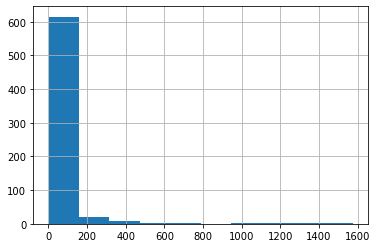

In [103]:
activities_df.groupby('user_id').count()['event_at'].value_counts().hist()

In [57]:
source_activity_count_df = column_count_values_and_pivot(activities_df, 'user_id', 'source')
source_activity_count_df.columns = ['activity_' + col for col in source_activity_count_df.columns]
source_activity_count_df

,activity_source_launcher,activity_source_pastActivities,activity_source_stickeralbum,activity_source_topics
user_id,,,,
67208,1.000,0.000,0.000,0.000
96278,24.000,0.000,0.000,1.000
112589,20.000,1.000,0.000,0.000
145612,252.000,6.000,0.000,0.000
182523,24.000,1.000,0.000,0.000
...,...,...,...,...
23766219,130.000,4.000,2.000,0.000
23766221,12.000,2.000,2.000,0.000
23766230,6.000,0.000,0.000,0.000


The type of activity could also be important. Users that experience the full range of activities might be more attracted to the app.

In [58]:
type_activity_count_df = column_count_values_and_pivot(activities_df, 'user_id', 'type')
type_activity_count_df.columns = ['activity_' + col for col in type_activity_count_df.columns]
type_activity_count_df

,activity_type_audiobook,activity_type_game,activity_type_traceable,activity_type_video
user_id,,,,
67208,0,1,0,0
96278,0,8,0,17
112589,2,11,5,3
145612,10,119,23,106
182523,0,8,4,13
...,...,...,...,...
23766219,0,78,18,40
23766221,0,11,3,2
23766230,0,2,2,2


The number of activities completed or interrupted is also an important insight. Do they play until the end and complete activities or just get tired of it?

In [59]:
completed_activity_count_df = column_count_values_and_pivot(activities_df, 'user_id', 'completed')
completed_activity_count_df.columns = ['activity_' + col for col in completed_activity_count_df.columns]
completed_activity_count_df

,activity_completed_False,activity_completed_True
user_id,,
67208,0,1
96278,13,12
112589,4,17
145612,82,176
182523,12,13
...,...,...
23766219,60,76
23766221,4,12
23766230,3,3


In [60]:
# join all the features into the activity features
dfs = [completed_activity_count_df, type_activity_count_df, source_activity_count_df, unique_fields_activities_df, numeric_fields_activities_df]
activity_features_df = reduce(lambda left, right: left.join(right, how='outer'), dfs)

In [61]:
activity_features_df

,activity_completed_False,activity_completed_True,activity_type_audiobook,activity_type_game,activity_type_traceable,activity_type_video,activity_source_launcher,activity_source_pastActivities,activity_source_stickeralbum,activity_source_topics,activity_location,activity_os_name,activities_duration,activities_downloading_time,activities_loading_time,activities_replay_times
user_id,,,,,,,,,,,,,,,,
67208,0,1,0,1,0,0,1.000,0.000,0.000,0.000,kr,Android,46.172,0.005,1.110,0.000
96278,13,12,0,8,0,17,24.000,0.000,0.000,1.000,us,iOS,4651.395,19.892,8.872,0.000
112589,4,17,2,11,5,3,20.000,1.000,0.000,0.000,mx,iOS,2698.965,74.304,35.799,0.000
145612,82,176,10,119,23,106,252.000,6.000,0.000,0.000,ru,Android,194665.908,351.441,340.281,0.000
182523,12,13,0,8,4,13,24.000,1.000,0.000,0.000,mx,Android,968.798,6871.628,11.373,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23766219,60,76,0,78,18,40,130.000,4.000,2.000,0.000,us,iOS,28979.718,87.039,81.114,0.000
23766221,4,12,0,11,3,2,12.000,2.000,2.000,0.000,us,iOS,1281.886,6.692,11.723,0.000
23766230,3,3,0,2,2,2,6.000,0.000,0.000,0.000,th,iOS,272.789,2.490,2.283,0.000


<a id='create_dataset_and_training'></a>

### Create Dataset and Training

To create the dataset we join the activity features, the subscription events features and the onboard events features. Remember that the last one contains information of wether the user generated an invoice or not

In [62]:
dfs = [activity_features_df, onboard_events_features, subscription_events_features ]
dataset = reduce(lambda left, right: left.join(right, how='outer'), dfs)

In [63]:
dataset

,activity_completed_False,activity_completed_True,activity_type_audiobook,activity_type_game,activity_type_traceable,activity_type_video,activity_source_launcher,activity_source_pastActivities,activity_source_stickeralbum,activity_source_topics,activity_location,activity_os_name,activities_duration,activities_downloading_time,activities_loading_time,activities_replay_times,event_name_onboarding_home,event_name_signup_age,event_name_signup_level,event_name_signup_result,onboard_level,onboard_success,event_name_subscription_enter,event_name_subscription_successful,subscription_enter_source_launcher,subscription_enter_source_parents,subscription_enter_source_postonboarding,subscription_enter_source_stickeralbum,subscription_enter_source_upsell_download_modal,subscription_id,invoices_subscription_id,invoices_purchased_at,invoices_refunded_invoice
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000,1.000,3.000,0.000,0.000,0.000,0.000,2082937.000,2082937.000,2020-12-14 20:47:54,0.000
12675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,NaN,NaN,NaN,NaN,NaN,2085879.000,NaN,NaT,NaN
50801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000,1.000,3.000,0.000,0.000,0.000,0.000,2097460.000,NaN,NaT,NaN
67208,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,kr,Android,46.172,0.005,1.110,0.000,NaN,NaN,NaN,NaN,NaN,NaN,7.000,1.000,2.000,5.000,0.000,0.000,0.000,2085846.000,NaN,NaT,NaN
96278,13.000,12.000,0.000,8.000,0.000,17.000,24.000,0.000,0.000,1.000,us,iOS,4651.395,19.892,8.872,0.000,NaN,NaN,NaN,NaN,NaN,NaN,3.000,1.000,3.000,0.000,0.000,0.000,0.000,2110658.000,2110658.000,2020-12-27 21:51:50,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23766230,3.000,3.000,0.000,2.000,2.000,2.000,6.000,0.000,0.000,0.000,th,iOS,272.789,2.490,2.283,0.000,1.000,1.000,1.000,1.000,2.000,True,1.000,1.000,0.000,0.000,1.000,0.000,0.000,2132429.000,NaN,NaT,NaN
23766242,1.000,1.000,0.000,0.000,0.000,2.000,1.000,0.000,1.000,0.000,us,iOS,156.237,0.568,0.000,0.000,1.000,1.000,1.000,1.000,2.000,True,1.000,1.000,0.000,0.000,1.000,0.000,0.000,2132434.000,NaN,NaT,NaN
23766243,7.000,4.000,0.000,7.000,1.000,3.000,10.000,1.000,0.000,0.000,mx,Android,637.797,24.039,21.369,0.000,1.000,1.000,1.000,1.000,2.000,True,1.000,1.000,0.000,0.000,1.000,0.000,0.000,2132435.000,NaN,NaT,NaN


 Now that we have joined the dataset let's check the nans again as the joining process could leave some fields with NaN value

In [64]:
dataset.isnull().sum()

activity_completed_False                           15715
activity_completed_True                            15715
activity_type_audiobook                            15715
activity_type_game                                 15715
activity_type_traceable                            15715
activity_type_video                                15715
activity_source_launcher                           15715
activity_source_pastActivities                     15715
activity_source_stickeralbum                       15715
activity_source_topics                             15715
activity_location                                  15715
activity_os_name                                   15715
activities_duration                                15715
activities_downloading_time                        15715
activities_loading_time                            15715
activities_replay_times                            15715
event_name_onboarding_home                          2714
event_name_signup_age          

Several things to take into account when dealing with the NaN's
- Activities counts will be filled with 0 as a NaN value means absence of playing that particular activity. Same with duration, downloading time, loading time, etc...
- Subscription enter counted events will be filled with the most frequent values as we assume that the user follows the normal procedure of subscription
- Invoices values nans will be engineered to be our target variable. A nan means that there is no invoice and the customer did not become a paying customer. 
- Most of the users subscribed succesfully. Two of them didn't but we will drop them
- For the users that somehow did not complete the onboarding process, we will impute them the most common values and assume that they followed the same onboarding process as most users
- The rest of categories like the os_name and location or the child level in the onboarding process will be imputed with the most common values

In [65]:
# Many users didn't go through the onboarding process (2714 users). Let's assume that they went through the same onboarding process as the majority of users and impute most frequent values
features_to_impute = ['event_name_onboarding_home','event_name_signup_age', 'event_name_signup_level', 'event_name_signup_result', 'onboard_level', 'onboard_success']
imp = SimpleImputer(strategy="most_frequent")
dataset[features_to_impute] = imp.fit_transform(dataset[features_to_impute])

In [66]:
# Activities counts will be filled with 0 as a NaN value means absence of playing that particular activity. Same with duration, downloading time, loading time, etc... However we must impute something into the activity os name and the location
features_to_impute = ['activity_os_name', 'activity_location']
imp = SimpleImputer(strategy="most_frequent")
dataset[features_to_impute] = imp.fit_transform(dataset[features_to_impute])

In [67]:
# drop those two users without a succesful registration (aparently they just did the onboarding and we are interested on knowing if a registered user is going to become a paying user)
dataset = dataset[~dataset['event_name_subscription_successful'].isna()]

In [68]:
# some users do not have a subscriptionid. They didn't enter the subscription succesful event either so we drop them too
dataset = dataset[~dataset['subscription_id'].isna()]

In [69]:
dataset.isnull().sum()

activity_completed_False                           15621
activity_completed_True                            15621
activity_type_audiobook                            15621
activity_type_game                                 15621
activity_type_traceable                            15621
activity_type_video                                15621
activity_source_launcher                           15621
activity_source_pastActivities                     15621
activity_source_stickeralbum                       15621
activity_source_topics                             15621
activity_location                                      0
activity_os_name                                       0
activities_duration                                15621
activities_downloading_time                        15621
activities_loading_time                            15621
activities_replay_times                            15621
event_name_onboarding_home                             0
event_name_signup_age          

In [70]:
features_to_impute = ['subscription_enter_source_launcher','subscription_enter_source_parents', 'subscription_enter_source_postonboarding', 'subscription_enter_source_stickeralbum', 'subscription_enter_source_upsell_download_modal']
imp = SimpleImputer(strategy="most_frequent")
dataset[features_to_impute] = imp.fit_transform(dataset[features_to_impute])

In [71]:
# let's create the output variable. If there is no data for refunded_invoice then it's not a paying user 
dataset['paying_customer'] = 1
dataset.loc[dataset['invoices_purchased_at'].isna(), 'paying_customer'] = 0

In [72]:
dataset

,activity_completed_False,activity_completed_True,activity_type_audiobook,activity_type_game,activity_type_traceable,activity_type_video,activity_source_launcher,activity_source_pastActivities,activity_source_stickeralbum,activity_source_topics,activity_location,activity_os_name,activities_duration,activities_downloading_time,activities_loading_time,activities_replay_times,event_name_onboarding_home,event_name_signup_age,event_name_signup_level,event_name_signup_result,onboard_level,onboard_success,event_name_subscription_enter,event_name_subscription_successful,subscription_enter_source_launcher,subscription_enter_source_parents,subscription_enter_source_postonboarding,subscription_enter_source_stickeralbum,subscription_enter_source_upsell_download_modal,subscription_id,invoices_subscription_id,invoices_purchased_at,invoices_refunded_invoice,paying_customer
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,us,iOS,NaN,NaN,NaN,NaN,1.000,1.000,1.000,1.000,2.000,True,3.000,1.000,3.000,0.000,0.000,0.000,0.000,2082937.000,2082937.000,2020-12-14 20:47:54,0.000,1
12675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,us,iOS,NaN,NaN,NaN,NaN,1.000,1.000,1.000,1.000,2.000,True,0.000,1.000,0.000,0.000,1.000,0.000,0.000,2085879.000,NaN,NaT,NaN,0
50801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,us,iOS,NaN,NaN,NaN,NaN,1.000,1.000,1.000,1.000,2.000,True,3.000,1.000,3.000,0.000,0.000,0.000,0.000,2097460.000,NaN,NaT,NaN,0
67208,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,kr,Android,46.172,0.005,1.110,0.000,1.000,1.000,1.000,1.000,2.000,True,7.000,1.000,2.000,5.000,0.000,0.000,0.000,2085846.000,NaN,NaT,NaN,0
96278,13.000,12.000,0.000,8.000,0.000,17.000,24.000,0.000,0.000,1.000,us,iOS,4651.395,19.892,8.872,0.000,1.000,1.000,1.000,1.000,2.000,True,3.000,1.000,3.000,0.000,0.000,0.000,0.000,2110658.000,2110658.000,2020-12-27 21:51:50,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23766219,60.000,76.000,0.000,78.000,18.000,40.000,130.000,4.000,2.000,0.000,us,iOS,28979.718,87.039,81.114,0.000,1.000,1.000,1.000,1.000,6.000,True,1.000,1.000,0.000,0.000,1.000,0.000,0.000,2132426.000,2132426.000,2021-01-07 23:54:38,0.000,1
23766221,4.000,12.000,0.000,11.000,3.000,2.000,12.000,2.000,2.000,0.000,us,iOS,1281.886,6.692,11.723,0.000,2.000,2.000,2.000,1.000,2.000,True,1.000,1.000,0.000,0.000,1.000,0.000,0.000,2132427.000,NaN,NaT,NaN,0
23766230,3.000,3.000,0.000,2.000,2.000,2.000,6.000,0.000,0.000,0.000,th,iOS,272.789,2.490,2.283,0.000,1.000,1.000,1.000,1.000,2.000,True,1.000,1.000,0.000,0.000,1.000,0.000,0.000,2132429.000,NaN,NaT,NaN,0


In [73]:
# And as a final step, drop those features that do not bring any value and fill the previous counts that are numeric
features_to_drop = ['invoices_subscription_id', 'subscription_id', 'invoices_purchased_at', 'invoices_refunded_invoice']
dataset = dataset.drop(features_to_drop, axis=1)
dataset.fillna(0)

,activity_completed_False,activity_completed_True,activity_type_audiobook,activity_type_game,activity_type_traceable,activity_type_video,activity_source_launcher,activity_source_pastActivities,activity_source_stickeralbum,activity_source_topics,activity_location,activity_os_name,activities_duration,activities_downloading_time,activities_loading_time,activities_replay_times,event_name_onboarding_home,event_name_signup_age,event_name_signup_level,event_name_signup_result,onboard_level,onboard_success,event_name_subscription_enter,event_name_subscription_successful,subscription_enter_source_launcher,subscription_enter_source_parents,subscription_enter_source_postonboarding,subscription_enter_source_stickeralbum,subscription_enter_source_upsell_download_modal,paying_customer
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8485,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,us,iOS,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,2.000,True,3.000,1.000,3.000,0.000,0.000,0.000,0.000,1
12675,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,us,iOS,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,2.000,True,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0
50801,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,us,iOS,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,2.000,True,3.000,1.000,3.000,0.000,0.000,0.000,0.000,0
67208,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,kr,Android,46.172,0.005,1.110,0.000,1.000,1.000,1.000,1.000,2.000,True,7.000,1.000,2.000,5.000,0.000,0.000,0.000,0
96278,13.000,12.000,0.000,8.000,0.000,17.000,24.000,0.000,0.000,1.000,us,iOS,4651.395,19.892,8.872,0.000,1.000,1.000,1.000,1.000,2.000,True,3.000,1.000,3.000,0.000,0.000,0.000,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23766219,60.000,76.000,0.000,78.000,18.000,40.000,130.000,4.000,2.000,0.000,us,iOS,28979.718,87.039,81.114,0.000,1.000,1.000,1.000,1.000,6.000,True,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1
23766221,4.000,12.000,0.000,11.000,3.000,2.000,12.000,2.000,2.000,0.000,us,iOS,1281.886,6.692,11.723,0.000,2.000,2.000,2.000,1.000,2.000,True,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0
23766230,3.000,3.000,0.000,2.000,2.000,2.000,6.000,0.000,0.000,0.000,th,iOS,272.789,2.490,2.283,0.000,1.000,1.000,1.000,1.000,2.000,True,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0


In [74]:
dataset.dtypes

activity_completed_False                           float64
activity_completed_True                            float64
activity_type_audiobook                            float64
activity_type_game                                 float64
activity_type_traceable                            float64
activity_type_video                                float64
activity_source_launcher                           float64
activity_source_pastActivities                     float64
activity_source_stickeralbum                       float64
activity_source_topics                             float64
activity_location                                   object
activity_os_name                                    object
activities_duration                                float64
activities_downloading_time                        float64
activities_loading_time                            float64
activities_replay_times                            float64
event_name_onboarding_home                         float

In [75]:
# Set the types of the dataset
categorical_fields = ['activity_location', 'activity_os_name', 'onboard_success', 'onboard_level', 'paying_customer']
dataset[categorical_fields] = dataset[categorical_fields].astype("category")
# the onboard level is going to be change to a string to not be mistaken with a numeric value
dataset['onboard_level'] = dataset['onboard_level'].cat.rename_categories(["low", "medium", "high"])

Let's train the model. We are goint to use CatBoost. Ensemble methods are a good way of reducing noise, bias and variance. Boosting is one of these methods and Catboost gives us an implementation that works well out of the box and that outputs and interpretable model. We also do not have to deal with normalisation and correlated features, so the data preprocessing is reduced even further

In [76]:
X = dataset.drop(['paying_customer'], axis=1)
categorical_indexes = [X.columns.get_loc(c) for c in X.select_dtypes('category').columns]
Y = dataset['paying_customer']
kfold = KFold(n_splits=2)
roc_curve_scores = []
for train_index, test_index in kfold.split(dataset):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    clf = CatBoostClassifier()
    clf.fit(x_train, y_train, cat_features=categorical_indexes)

Learning rate set to 0.037796
0:	learn: 0.6890199	total: 140ms	remaining: 2m 19s
1:	learn: 0.6848375	total: 196ms	remaining: 1m 37s
2:	learn: 0.6813130	total: 253ms	remaining: 1m 24s
3:	learn: 0.6781422	total: 312ms	remaining: 1m 17s
4:	learn: 0.6742248	total: 368ms	remaining: 1m 13s
5:	learn: 0.6702916	total: 421ms	remaining: 1m 9s
6:	learn: 0.6669778	total: 458ms	remaining: 1m 4s
7:	learn: 0.6642686	total: 525ms	remaining: 1m 5s
8:	learn: 0.6614701	total: 587ms	remaining: 1m 4s
9:	learn: 0.6584721	total: 639ms	remaining: 1m 3s
10:	learn: 0.6562292	total: 679ms	remaining: 1m 1s
11:	learn: 0.6537682	total: 735ms	remaining: 1m
12:	learn: 0.6516102	total: 774ms	remaining: 58.8s
13:	learn: 0.6497541	total: 823ms	remaining: 57.9s
14:	learn: 0.6478529	total: 875ms	remaining: 57.5s
15:	learn: 0.6463488	total: 929ms	remaining: 57.1s
16:	learn: 0.6446886	total: 985ms	remaining: 56.9s
17:	learn: 0.6433792	total: 1.01s	remaining: 55.3s
18:	learn: 0.6418810	total: 1.09s	remaining: 56.3s
19:	learn

<a id='evaluation'></a>

### Evaluation

This is a binary classification task (customer will pay or not). One of the ways to evaluate this is through a ROC curve, which measures the performance of a classifier when using different probabilty thresholds to classify an instance into one of the two options. We obviously want to get right our predictions (true positives) but we don't want to wrongly classify a user as a paying customer (false positives). The balance between the two depends on the use case. For this kind of use case a false positive does not have severe consequences, so we can afford a relatively high number of them. On the other hand, in other use cases such as cancer detection, we cannot afford many false positives. 

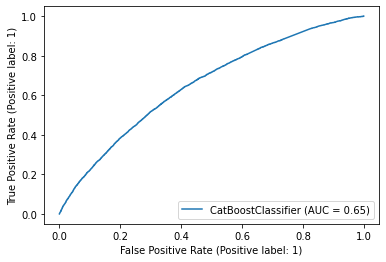

In [77]:
plot_roc_curve(clf, x_test, y_test) 

Our classifier has a AUC of 0.65. That means that is better than a random guess which can already provide value. It could be improved by also considering the time dimension (did users play a lot the first few days or consistently during the trial?). We leave that as future work

precision-recall is also used when working with unbalanced datasets (not our case, see below). In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

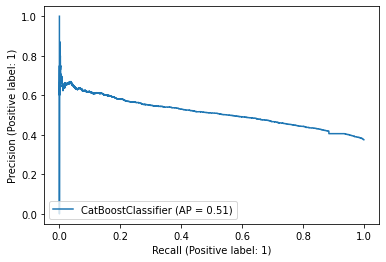

In [78]:
plot_precision_recall_curve(clf, x_test, y_test)

In [79]:
# the problem is not unbalanced
dataset['paying_customer'].value_counts()

0    24609
1    17374
Name: paying_customer, dtype: int64

<a id='interpretability'></a>

### Interpretability

An important thing is also to interpret the model. It can provide us insights on which factors are more important on our customer churn and what are the focus points. For this study we will use ShapValues which works nicely with the CatBoost library

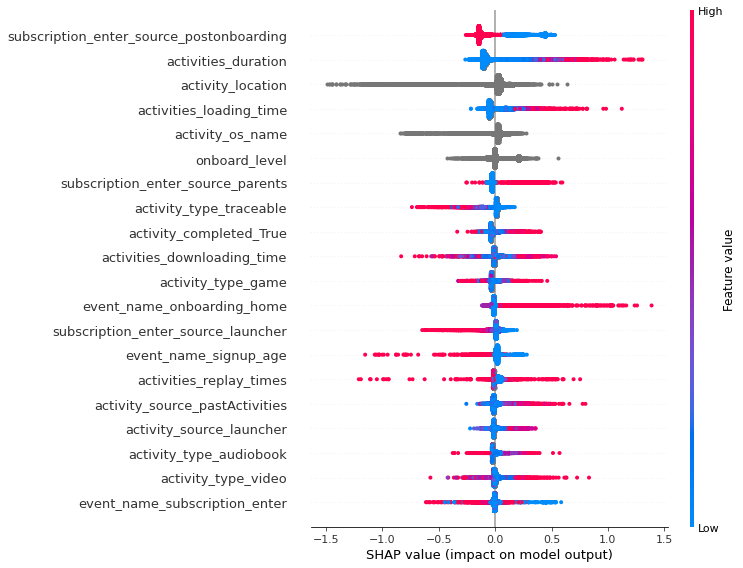

In [80]:
shap_values = clf.get_feature_importance(Pool(x_train, label=y_train,cat_features=categorical_indexes),
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, x_train)

We can see the impact of the most important attributes in the chart. If the points are in red it means that the feature takes higher values. If they are to the left it means that they affect negatively the possibility of getting a paid subscription and viceversa. Some insights: 
- We can see that surprisingly, those users that are shown the paywall after onboarding are less likely to become paying customers. This could be misleading as not many users are not shown the paywall after onboarding. However, in this dataset, those users become paying customers more easily (see graphs below) and therefore, might be just a misinterpretation. More data will clarify this point
- The more the user plays, the more likely he is going to become a paying customer. Same with loading time
- Paywalls shown in the parents area have a bigger impact on turning a customer into a paying one. It could mean that users that really get into the parents area are more interested on enrolling. 
- Users that play past activities are most likely to become customers. 
- Onboard level also has an impact. Seems that users that put their children into the higher levels are most likely to become paying customers
- Users of some countries are more likely to pay for the app

See more plots below to understand better the impact of the variables

We also include a correlation matrix. We can see that the higher correlations are usage of the app with more activities completed and the duration of the usage

In [104]:
cor_dataset = dataset
cor_dataset['paying_customer'] = cor_dataset['paying_customer'].astype('float')
cor_dataset.corr()[cor_dataset.corr()['paying_customer']>0.1]

,activity_completed_False,activity_completed_True,activity_type_audiobook,activity_type_game,activity_type_traceable,activity_type_video,activity_source_launcher,activity_source_pastActivities,activity_source_stickeralbum,activity_source_topics,activities_duration,activities_downloading_time,activities_loading_time,activities_replay_times,event_name_onboarding_home,event_name_signup_age,event_name_signup_level,event_name_signup_result,event_name_subscription_enter,event_name_subscription_successful,subscription_enter_source_launcher,subscription_enter_source_parents,subscription_enter_source_postonboarding,subscription_enter_source_stickeralbum,subscription_enter_source_upsell_download_modal,paying_customer
activity_completed_True,0.750,1.000,0.665,0.919,0.798,0.801,0.946,0.677,0.194,0.120,0.536,0.056,0.082,0.258,0.047,0.006,0.041,0.011,0.156,NaN,0.163,0.068,-0.071,0.047,0.003,0.125
activity_type_game,0.879,0.919,0.656,1.000,0.688,0.737,0.959,0.729,0.158,0.081,0.518,0.058,0.076,0.270,0.051,0.009,0.046,0.013,0.157,NaN,0.164,0.057,-0.062,0.050,0.000,0.117
activity_type_video,0.834,0.801,0.613,0.737,0.704,1.000,0.868,0.604,0.183,0.108,0.452,0.058,0.070,0.153,0.050,0.004,0.036,0.007,0.142,NaN,0.150,0.066,-0.081,0.050,0.002,0.113
activity_source_launcher,0.917,0.946,0.699,0.959,0.814,0.868,1.000,0.686,0.157,0.052,0.524,0.061,0.081,0.229,0.056,0.007,0.048,0.009,0.161,NaN,0.170,0.059,-0.073,0.053,-0.001,0.119
activities_duration,0.436,0.536,0.340,0.518,0.403,0.452,0.524,0.388,0.090,0.050,1.000,0.045,0.075,0.189,0.013,-0.012,0.005,0.001,0.118,NaN,0.127,0.046,-0.059,0.030,-0.002,0.117
paying_customer,0.099,0.125,0.084,0.117,0.086,0.113,0.119,0.095,0.032,0.034,0.117,0.011,0.015,0.027,0.019,-0.014,0.011,0.008,0.048,NaN,0.060,0.054,-0.092,0.009,-0.001,1.000


In [82]:
def filter_by_top_n(data, n, category_name):
    top_n_categories = data[category_name].value_counts().nlargest(n).index
    result_df = data[data[category_name].isin(top_n_categories)]
    result_df[category_name].cat.set_categories(result_df[category_name].unique(), inplace=True)
    return result_df


def plot_top_n(data, n, category):
    return sns.countplot(x=category, data=filter_by_top_n(data, n, category), hue='paying_customer')

<AxesSubplot:xlabel='activity_location', ylabel='count'>

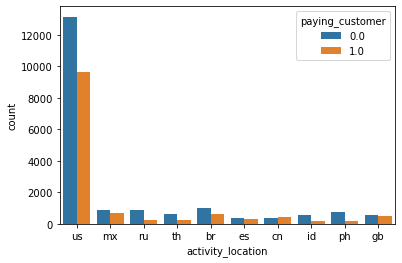

In [83]:
# Users of some countries are more likely to pay for the app. We limit to the top 10 because there are so many countries.
plot_top_n(dataset, 10, 'activity_location')

<AxesSubplot:xlabel='subscription_enter_source_postonboarding', ylabel='count'>

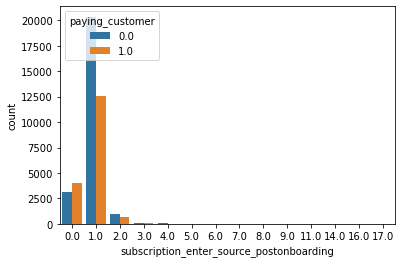

In [84]:
sns.countplot(data=dataset, x='subscription_enter_source_postonboarding', hue='paying_customer' )

<AxesSubplot:xlabel='paying_customer', ylabel='activities_duration'>

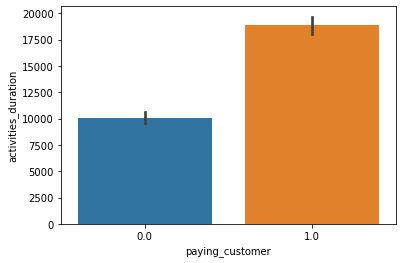

In [85]:
# Clearly the duration is bigger with paying customers
sns.barplot(x="paying_customer", y="activities_duration", data=dataset)

<AxesSubplot:xlabel='activity_os_name', ylabel='count'>

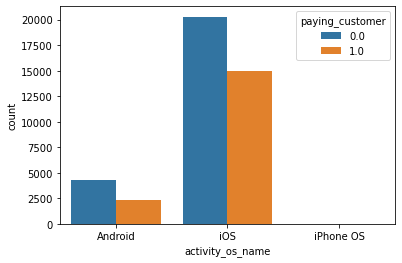

In [86]:
sns.countplot(data=dataset, x='activity_os_name', hue='paying_customer' )

<AxesSubplot:xlabel='subscription_enter_source_parents', ylabel='count'>

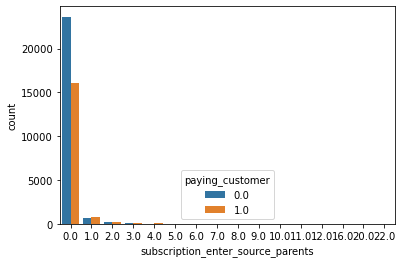

In [87]:
sns.countplot(data=dataset, x='subscription_enter_source_parents', hue='paying_customer' )

<AxesSubplot:xlabel='subscription_enter_source_parents', ylabel='count'>

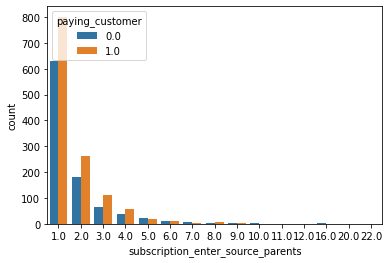

In [88]:
# zoom into the paywalls shown more than one time in the parents section. They have a greater conversion rate
sns.countplot(data=dataset[dataset['subscription_enter_source_parents']> 0], x='subscription_enter_source_parents', hue='paying_customer' )

<AxesSubplot:xlabel='onboard_level', ylabel='count'>

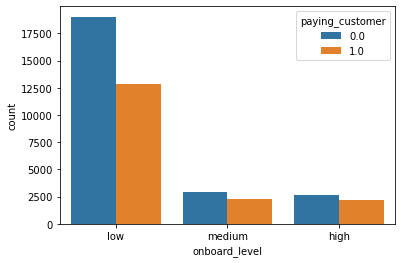

In [89]:
# Children in higher levels are more likely to become paying users
sns.countplot(data=dataset, x='onboard_level', hue='paying_customer' )

<AxesSubplot:xlabel='paying_customer', ylabel='activity_source_pastActivities'>

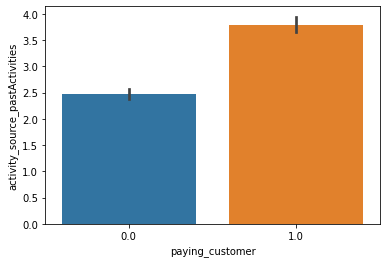

In [90]:
sns.barplot(x="paying_customer", y="activity_source_pastActivities", data=dataset)

<AxesSubplot:xlabel='paying_customer', ylabel='event_name_onboarding_home'>

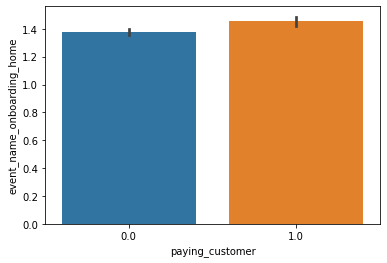

In [91]:
sns.barplot(x="paying_customer", y="event_name_onboarding_home", data=dataset)

<AxesSubplot:xlabel='paying_customer', ylabel='activity_type_game'>

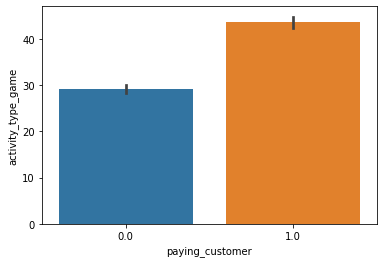

In [92]:
sns.barplot(x="paying_customer", y="activity_type_game", data=dataset)

<a id='conclusion'></a>

### Conclusion

In most of the data science projects, a big deal of the time is spent on preparing the data. This was no exception as there was a lot of data massaging and wrangling involved in engineering features out of the dataset, which took most of the time of this exercise. 
There are indeed several factors that influence whether the user will become a paying customer or not. In general, greater usage times and more activities completed help to become a paying customer. But also some factors like the location or information about the onboarding process can provide inmmediate information, without waiting for the customer to use the app further. The OS is also an important factor. Finally, some paywalls are more effective that others, specially those shown in the parents section, which means that parents that get into the parents section are more likely to become customers. 

<a id='future_work'></a>

### Future Work

- Note that here we are aggregating the events for each customer during the whole trial. We could aggregate this events for day 1, day 2, etc... of the trial, as the impact of one variable in day 1 does not have to be the same as in the last days of the trial. 
- Another point to improve is the model. Since this is a sequence prediction problem, models like LTSM could be more effective since they are able to memorise the order of the events instead of just aggregating them without considering their sequence. 
- A better handling of outliers could also be interesting. We could eliminate them and work with a much more constrained dataset that only contains the activities of the "average" user.
- It could be interesting to have different models for each of the days of the trial as the statistical correlations between features could be different each day. In the first day of the trial the usage pattern could be different in comparison to the days after. For instance, most users could be more active during the first stages of the trial but if they keep being active day after day, is a good hint of a possible paying customer. 